In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
%matplotlib inline


In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']


** Use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to smooth the series(get rid of peaks in Monday and Friday). I use rolling window of 15 and power of 3 **

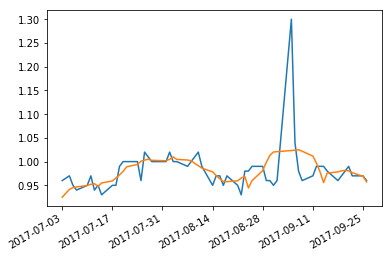

In [3]:
##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()

**Define a rolling window function that calculate following statistic for one column:**  
1.Mean  
2.Standard Deviation  
3.Median  
4.Min  
5.Max  
6.Rooted Mean Square  
7.[Crest Factor](https://en.wikipedia.org/wiki/Crest_factor)  
8.[Zero-crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate)(here is Mean-crossing Rate)  
9.Trend(Slope of linear regression)

In [8]:
pred = yield_data_filtered.shift(1)
pred.head()

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-02,0.100098,0.061363,0.153196,0.271778,0.687016,1.160258,2.054386,2.757788,3.284833,4.120350,4.238709
2009-12-03,0.086674,0.056951,0.154331,0.284103,0.716897,1.195020,2.092698,2.809209,3.335632,4.177983,4.290404
2009-12-04,0.073826,0.052056,0.155113,0.295601,0.741628,1.222619,2.124901,2.851474,3.378137,4.225860,4.334141
2009-12-07,0.061699,0.047002,0.155626,0.306321,0.761818,1.244129,2.151963,2.885915,3.413430,4.265017,4.370661


In [13]:
def predictTargetNew(target):
    print("******predicting:",target,"*******")
    #score
    r2 = r2_score(yield_data_filtered[target][1:],pred[target][1:])
    rmse = np.sqrt(mean_squared_error(yield_data_filtered[target][1:],pred[target][1:]))
    print(target," R sq:",r2)
    print(target," RMSE:",rmse)

In [14]:
for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']:
    predictTargetNew(target)

******predicting: 1-month *******
1-month  R sq: 0.999252667242
1-month  RMSE: 0.00610987394817
******predicting: 3-month *******
3-month  R sq: 0.999659717515
3-month  RMSE: 0.00457640628436
******predicting: 6-month *******
6-month  R sq: 0.99968018481
6-month  RMSE: 0.00489977310294
******predicting: 1-year *******
1-year  R sq: 0.999600639342
1-year  RMSE: 0.00592553700648
******predicting: 2-year *******
2-year  R sq: 0.999071418399
2-year  RMSE: 0.0098613321613
******predicting: 3-year *******
3-year  R sq: 0.998703680379
3-year  RMSE: 0.0136183204123
******predicting: 5-year *******
5-year  R sq: 0.998559824854
5-year  RMSE: 0.0180034156417
******predicting: 7-year *******
7-year  R sq: 0.998687897269
7-year  RMSE: 0.0195302612386
******predicting: 10-year *******
10-year  R sq: 0.998940400919
10-year  RMSE: 0.0190053115221
******predicting: 20-year *******
20-year  R sq: 0.999259232032
20-year  RMSE: 0.018853108936
******predicting: 30-year *******
30-year  R sq: 0.999202529324